<a href="https://colab.research.google.com/github/Gliitchhh410/PyTorch_Fundmentals/blob/main/08_Vision_Transformer_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# For this notebook to run with updated APIs, we need torch 1.12+ and torchvision 0.13+
try:
    import torch
    import torchvision
    assert int(torch.__version__.split(".")[1]) >= 12 or int(torch.__version__.split(".")[0]) == 2, "torch version should be 1.12+"
    assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version should be 0.13+"
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except:
    print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")
    !pip3 install -U torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")

torch version: 2.3.1+cu121
torchvision version: 0.18.1+cu121


In [2]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !mv pytorch-deep-learning/helper_functions.py . # get the helper_functions.py script
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves

[INFO] Couldn't find torchinfo... installing it.
[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 4056, done.
remote: Total 4056 (delta 0), reused 0 (delta 0), pack-reused 4056
Receiving objects: 100% (4056/4056), 646.90 MiB | 26.56 MiB/s, done.
Resolving deltas: 100% (2371/2371), done.
Updating files: 100% (248/248), done.


In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [4]:
# Download pizza, steak, sushi images from GitHub
image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")
image_path

[INFO] Did not find data/pizza_steak_sushi directory, creating one...
[INFO] Downloading pizza_steak_sushi.zip from https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip...
[INFO] Unzipping pizza_steak_sushi.zip data...


PosixPath('data/pizza_steak_sushi')

In [5]:
# Setup directory paths to train and test images
train_dir = image_path / "train"
test_dir = image_path / "test"

In [6]:
# Create image size (from Table 3 in the ViT paper)
IMG_SIZE = 224

# Create transform pipeline manually
manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])
print(f"Manually created transforms: {manual_transforms}")

Manually created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)


In [7]:
# Set the batch size
BATCH_SIZE = 32 # this is lower than the ViT paper but it's because we're starting small

# Create data loaders
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transforms, # use manually created transforms
    batch_size=BATCH_SIZE
)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x795194cf8730>,
 ['pizza', 'steak', 'sushi'])

In [8]:
# Get a batch of images
image_batch, label_batch = next(iter(train_dataloader))

# Get a single image from the batch
image, label = image_batch[0], label_batch[0]

# View the batch shapes
image.shape, label

(torch.Size([3, 224, 224]), tensor(0))

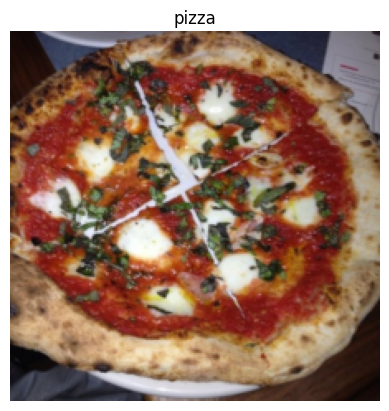

In [9]:
# Plot image with matplotlib
plt.imshow(image.permute(1, 2, 0)) # rearrange image dimensions to suit matplotlib [color_channels, height, width] -> [height, width, color_channels]
plt.title(class_names[label])
plt.axis(False);

In [10]:
# Create example values
height = 224 # H ("The training resolution is 224.")
width = 224 # W
color_channels = 3 # C
patch_size = 16 # P

# Calculate N (number of patches)
number_of_patches = int((height * width) / patch_size**2)
print(f"Number of patches (N) with image height (H={height}), width (W={width}) and patch size (P={patch_size}): {number_of_patches}")

Number of patches (N) with image height (H=224), width (W=224) and patch size (P=16): 196


In [11]:
# Input shape (this is the size of a single image)
embedding_layer_input_shape = (height, width, color_channels)

# Output shape
embedding_layer_output_shape = (number_of_patches, patch_size**2 * color_channels)

print(f"Input shape (single 2D image): {embedding_layer_input_shape}")
print(f"Output shape (single 2D image flattened into patches): {embedding_layer_output_shape}")

Input shape (single 2D image): (224, 224, 3)
Output shape (single 2D image flattened into patches): (196, 768)


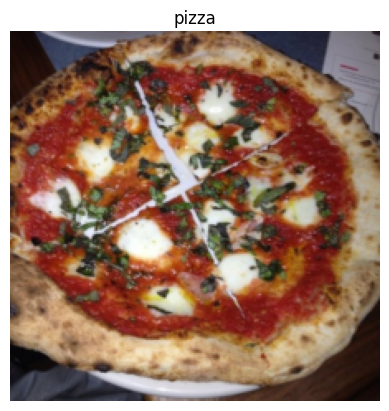

In [12]:
# View single image
plt.imshow(image.permute(1, 2, 0)) # adjust for matplotlib
plt.title(class_names[label])
plt.axis(False);

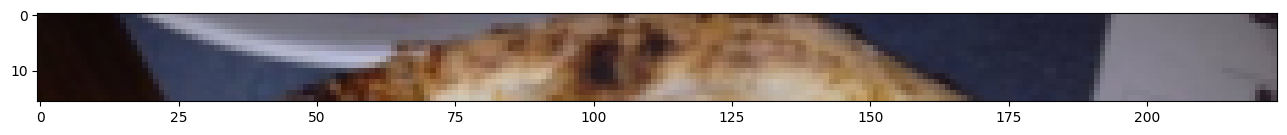

In [13]:
# Change image shape to be compatible with matplotlib (color_channels, height, width) -> (height, width, color_channels)
image_permuted = image.permute(1, 2, 0)

# Index to plot the top row of patched pixels
patch_size = 16
plt.figure(figsize=(patch_size, patch_size))
plt.imshow(image_permuted[:patch_size, :, :]);

Number of patches per row: 14.0
Patch size: 16 pixels x 16 pixels


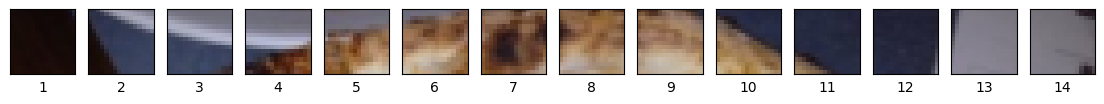

In [14]:
# Setup hyperparameters and make sure img_size and patch_size are compatible
img_size = 224
patch_size = 16
num_patches = img_size/patch_size
assert img_size % patch_size == 0, "Image size must be divisible by patch size"
print(f"Number of patches per row: {num_patches}\nPatch size: {patch_size} pixels x {patch_size} pixels")

# Create a series of subplots
fig, axs = plt.subplots(nrows=1,
                        ncols=img_size // patch_size, # one column for each patch
                        figsize=(num_patches, num_patches),
                        sharex=True,
                        sharey=True)

# Iterate through number of patches in the top row
for i, patch in enumerate(range(0, img_size, patch_size)):
    axs[i].imshow(image_permuted[:patch_size, patch:patch+patch_size, :]); # keep height index constant, alter the width index
    axs[i].set_xlabel(i+1) # set the label
    axs[i].set_xticks([])
    axs[i].set_yticks([])

Number of patches per row: 14.0        
Number of patches per column: 14.0        
Total patches: 196.0        
Patch size: 16 pixels x 16 pixels


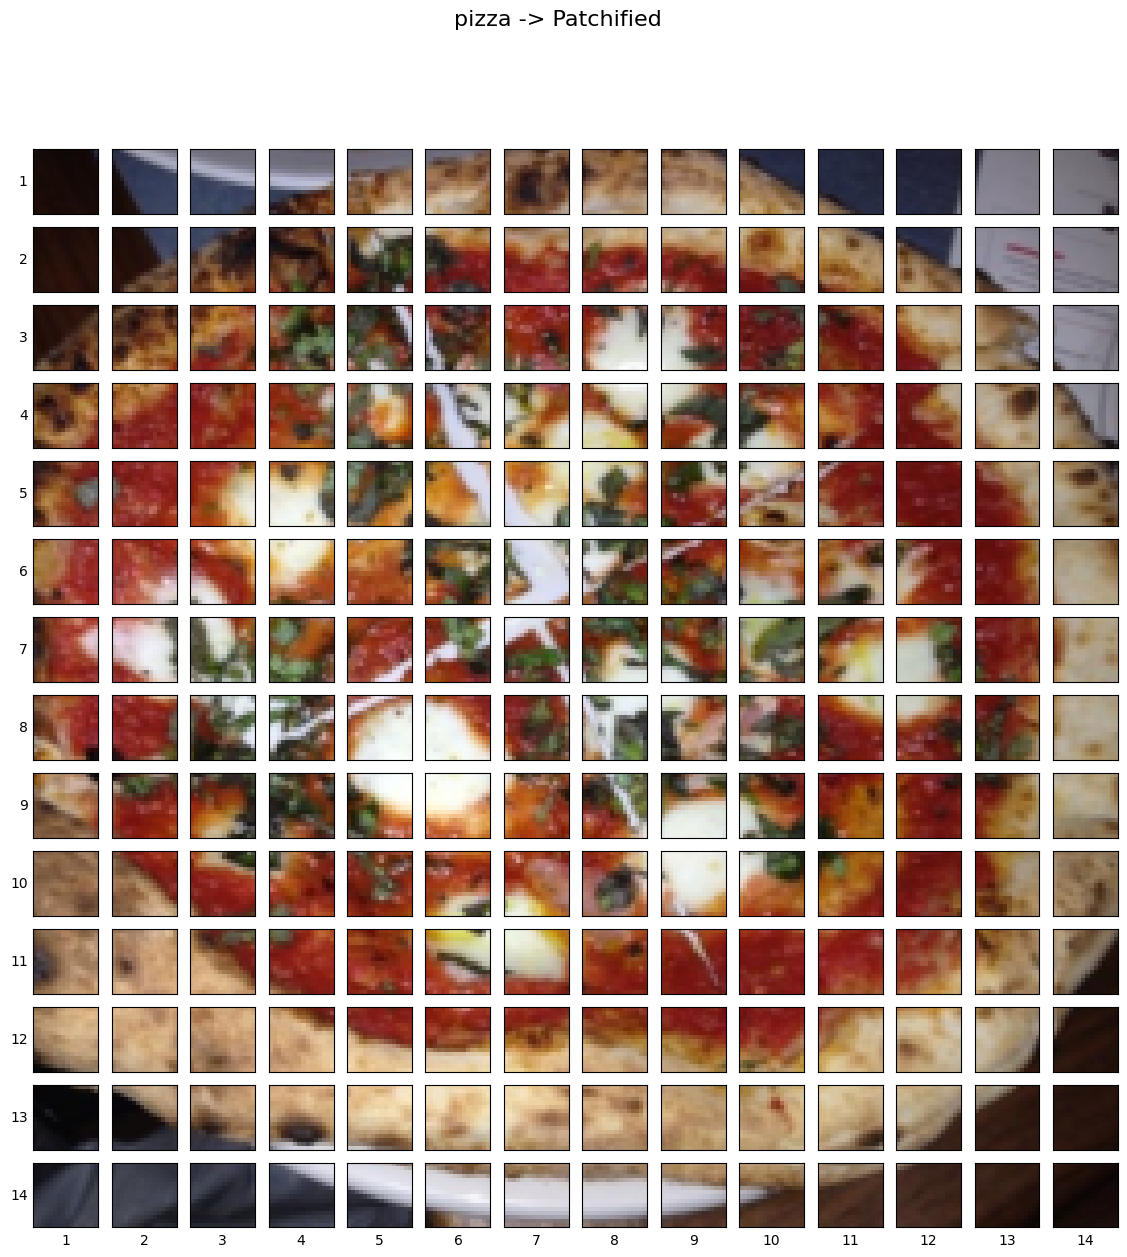

In [15]:
# Setup hyperparameters and make sure img_size and patch_size are compatible
img_size = 224
patch_size = 16
num_patches = img_size/patch_size
assert img_size % patch_size == 0, "Image size must be divisible by patch size"
print(f"Number of patches per row: {num_patches}\
        \nNumber of patches per column: {num_patches}\
        \nTotal patches: {num_patches*num_patches}\
        \nPatch size: {patch_size} pixels x {patch_size} pixels")

# Create a series of subplots
fig, axs = plt.subplots(nrows=img_size // patch_size, # need int not float
                        ncols=img_size // patch_size,
                        figsize=(num_patches, num_patches),
                        sharex=True,
                        sharey=True)

# Loop through height and width of image
for i, patch_height in enumerate(range(0, img_size, patch_size)): # iterate through height
    for j, patch_width in enumerate(range(0, img_size, patch_size)): # iterate through width

        # Plot the permuted image patch (image_permuted -> (Height, Width, Color Channels))
        axs[i, j].imshow(image_permuted[patch_height:patch_height+patch_size, # iterate through height
                                        patch_width:patch_width+patch_size, # iterate through width
                                        :]) # get all color channels

        # Set up label information, remove the ticks for clarity and set labels to outside
        axs[i, j].set_ylabel(i+1,
                             rotation="horizontal",
                             horizontalalignment="right",
                             verticalalignment="center")
        axs[i, j].set_xlabel(j+1)
        axs[i, j].set_xticks([])
        axs[i, j].set_yticks([])
        axs[i, j].label_outer()

# Set a super title
fig.suptitle(f"{class_names[label]} -> Patchified", fontsize=16)
plt.show()

In [16]:
from torch import nn



patch_size = 16



conv2d = nn.Conv2d(in_channels = 3,
                   out_channels = 768,
                   kernel_size= patch_size,
                   stride = patch_size,
                   padding= 0)

conv2d


Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))

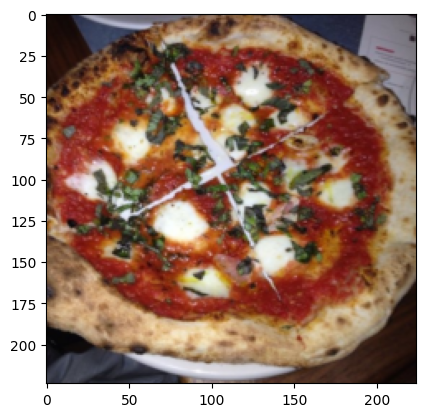

In [17]:
plt.imshow(image.permute(1, 2, 0))

In [18]:
image_out_of_conv2d = conv2d(image.unsqueeze(0))
image_out_of_conv2d.shape

torch.Size([1, 768, 14, 14])

Showing random convolutional feature maps from indexes: [121, 550, 10, 723, 711]


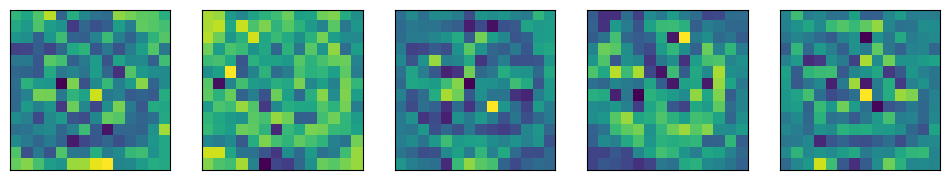

In [19]:
# Plot random 5 convolutional feature maps
import random
random_indexes = random.sample(range(0, 758), k=5) # pick 5 numbers between 0 and the embedding size
print(f"Showing random convolutional feature maps from indexes: {random_indexes}")

# Create plot
fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(12, 12))

# Plot random image feature maps
for i, idx in enumerate(random_indexes):
    image_conv_feature_map = image_out_of_conv2d[:, idx, :, :] # index on the output tensor of the convolutional layer
    axs[i].imshow(image_conv_feature_map.squeeze().detach().numpy())
    axs[i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[]);

In [20]:
# Get a single feature map in tensor form
single_feature_map = image_out_of_conv2d[:, 0, :, :]
single_feature_map, single_feature_map.requires_grad

(tensor([[[ 2.2032e-03, -2.9982e-02,  1.5694e-01,  2.9477e-02, -1.8158e-02,
           -5.0949e-02, -7.7659e-02,  1.8493e-02,  5.5485e-02, -1.6486e-02,
            3.5666e-02,  2.1041e-02,  4.6886e-02,  3.6135e-02],
          [-5.1722e-03,  1.5145e-02,  1.8956e-02, -1.2087e-02, -6.4402e-02,
           -1.2387e-01, -1.1256e-01, -1.3342e-01, -8.5134e-02, -1.2048e-01,
            2.8263e-02, -6.6087e-03, -4.7805e-02,  4.8733e-03],
          [-1.3249e-02, -6.9020e-02, -9.2013e-03, -7.4193e-02, -1.0900e-01,
            3.2389e-02,  1.5566e-02,  7.9172e-02, -3.5130e-02, -7.8369e-02,
           -9.6505e-02, -1.6478e-02, -4.5178e-02,  4.0816e-02],
          [ 2.1563e-02, -1.0102e-01, -8.0171e-02, -3.4228e-02,  1.6916e-02,
            5.3823e-02, -1.0509e-01, -2.7324e-02, -9.3151e-02,  1.8386e-01,
           -1.2466e-01, -8.6640e-02, -6.3190e-02, -1.3690e-01],
          [-5.2234e-02, -9.9952e-02, -6.6986e-02,  8.8431e-02, -3.3585e-02,
           -2.4535e-02, -5.2558e-02, -2.0707e-01, -1.5056e-0

In [21]:
print(image_out_of_conv2d.shape)
print(single_feature_map.shape)

torch.Size([1, 768, 14, 14])
torch.Size([1, 14, 14])


In [22]:
flatten_layer = nn.Flatten(start_dim = 2, end_dim = 3)

flatten_layer(image_out_of_conv2d).shape

torch.Size([1, 768, 196])

Original image shape: torch.Size([3, 224, 224])
Image feature map shape: torch.Size([1, 768, 14, 14])
Flattened image feature map shape: torch.Size([1, 768, 196])


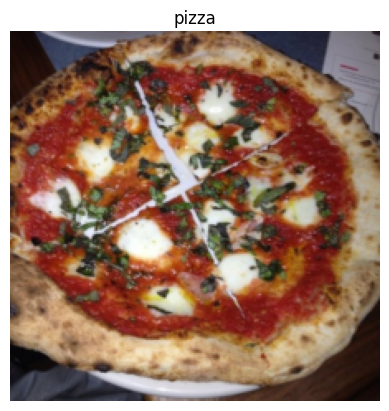

In [23]:
# 1. View single image
plt.imshow(image.permute(1, 2, 0)) # adjust for matplotlib
plt.title(class_names[label])
plt.axis(False);
print(f"Original image shape: {image.shape}")

# 2. Turn image into feature maps
image_out_of_conv = conv2d(image.unsqueeze(0)) # add batch dimension to avoid shape errors
print(f"Image feature map shape: {image_out_of_conv.shape}")

# 3. Flatten the feature maps
image_out_of_conv_flattened = flatten_layer(image_out_of_conv)
print(f"Flattened image feature map shape: {image_out_of_conv_flattened.shape}")

In [24]:
image_out_of_conv_flattened.permute(0,2,1).shape

torch.Size([1, 196, 768])

In [25]:
image_out_of_conv_flattened_reshaped = image_out_of_conv_flattened.permute(0,2,1)
single_flattened_feature_map = image_out_of_conv_flattened_reshaped[:,:,0]


single_flattened_feature_map

tensor([[ 2.2032e-03, -2.9982e-02,  1.5694e-01,  2.9477e-02, -1.8158e-02,
         -5.0949e-02, -7.7659e-02,  1.8493e-02,  5.5485e-02, -1.6486e-02,
          3.5666e-02,  2.1041e-02,  4.6886e-02,  3.6135e-02, -5.1722e-03,
          1.5145e-02,  1.8956e-02, -1.2087e-02, -6.4402e-02, -1.2387e-01,
         -1.1256e-01, -1.3342e-01, -8.5134e-02, -1.2048e-01,  2.8263e-02,
         -6.6087e-03, -4.7805e-02,  4.8733e-03, -1.3249e-02, -6.9020e-02,
         -9.2013e-03, -7.4193e-02, -1.0900e-01,  3.2389e-02,  1.5566e-02,
          7.9172e-02, -3.5130e-02, -7.8369e-02, -9.6505e-02, -1.6478e-02,
         -4.5178e-02,  4.0816e-02,  2.1563e-02, -1.0102e-01, -8.0171e-02,
         -3.4228e-02,  1.6916e-02,  5.3823e-02, -1.0509e-01, -2.7324e-02,
         -9.3151e-02,  1.8386e-01, -1.2466e-01, -8.6640e-02, -6.3190e-02,
         -1.3690e-01, -5.2234e-02, -9.9952e-02, -6.6986e-02,  8.8431e-02,
         -3.3585e-02, -2.4535e-02, -5.2558e-02, -2.0707e-01, -1.5056e-01,
         -8.5696e-02, -4.0795e-02, -1.

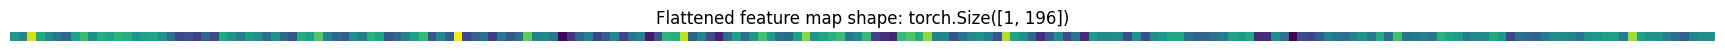

In [26]:
# Plot the flattened feature map visually
plt.figure(figsize=(22, 22))
plt.imshow(single_flattened_feature_map.detach().numpy())
plt.title(f"Flattened feature map shape: {single_flattened_feature_map.shape}")
plt.axis(False);

In [27]:
class PatchEmbedding(nn.Module):
  def __init__(self, in_channels = 3,
               patch_size = 16,
               embedding_int = 768,
               ):
    super().__init__()

    self.patcher = nn.Conv2d(in_channels = in_channels,
                             out_channels = embedding_int,
                             kernel_size= patch_size,
                             stride = patch_size,
                             padding= 0)


    self.flatten_layer = nn.Flatten(start_dim = 2, end_dim = 3)


  def forward(self, x):
    image_resolution = x.shape[-1]

    assert image_resolution % patch_size == 0, f"Wrong input image size"
    x = self.patcher(x)
    x = self.flatten_layer(x)
    return x.permute(0,2,1)

In [28]:
set_seeds()

patchify = PatchEmbedding()


print(f"Input image size: {image.unsqueeze(0).shape}")

patch_embedded_image = patchify(image.unsqueeze(0))

print(f"Output image size: {patch_embedded_image.shape}")

Input image size: torch.Size([1, 3, 224, 224])
Output image size: torch.Size([1, 196, 768])


In [31]:
rand_image_tensor = torch.randn((1, 3, 224, 224))
rand_image_tensor_bad = torch.randn((1, 3, 250, 250))



patchify(rand_image_tensor)

tensor([[[ 0.2929,  0.1295, -0.7469,  ...,  0.1289, -0.6862, -0.6327],
         [ 0.6400,  0.7767, -0.5704,  ..., -0.6052,  0.0827, -0.6409],
         [-0.4620,  0.9109,  0.0685,  ..., -0.4283, -1.1453, -0.6027],
         ...,
         [ 0.1048, -0.7745, -0.4074,  ..., -0.1936, -0.4413,  0.8689],
         [ 0.8032,  0.8950,  0.3532,  ...,  0.4590, -0.8367, -0.7793],
         [ 0.0555,  1.1857,  0.4692,  ...,  0.4221, -1.3477,  0.0664]]],
       grad_fn=<PermuteBackward0>)

In [32]:
patchify(rand_image_tensor_bad)

AssertionError: Wrong input image size

In [33]:
batch_size = patch_embedded_image.shape[0]
embedding_dimenstion = patch_embedded_image.shape[-1]
batch_size, embedding_dimenstion

(1, 768)

In [35]:
class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dimenstion),
                           requires_grad = True)
class_token

Parameter containing:
tensor([[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 

In [36]:
class_token.shape

torch.Size([1, 1, 768])

In [37]:
patch_embedded_image.shape

torch.Size([1, 196, 768])

In [40]:
patch_embedded_image_with_class_embedding = torch.cat([class_token, patch_embedded_image], dim = 1)
patch_embedded_image_with_class_embedding.shape

torch.Size([1, 197, 768])

In [41]:
# Show the first 10 examples of the class_token
print(class_token[:, :, :10])

# Print the class_token shape
print(f"Class token shape: {class_token.shape} -> [batch_size, number_of_tokens, embedding_dimension]")

tensor([[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]], grad_fn=<SliceBackward0>)
Class token shape: torch.Size([1, 1, 768]) -> [batch_size, number_of_tokens, embedding_dimension]


In [42]:
patch_embedded_image_with_class_embedding, patch_embedded_image_with_class_embedding.shape

(tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
          [-0.0720,  0.0102, -0.0378,  ...,  0.0342, -0.0404,  0.0358],
          [-0.2834,  0.2195, -0.0221,  ...,  0.2904, -0.1860,  0.0389],
          ...,
          [-0.1524, -0.0231, -0.0507,  ...,  0.1375, -0.1198,  0.1081],
          [-0.1294,  0.0015, -0.0212,  ...,  0.0447, -0.0764,  0.0666],
          [-0.0630, -0.0118, -0.0410,  ...,  0.0507, -0.0411,  0.0324]]],
        grad_fn=<CatBackward0>),
 torch.Size([1, 197, 768]))

In [48]:
number_of_patches = int((height*width)/ patch_size**2)


embedding_dimenstion = patch_embedded_image_with_class_embedding.shape[-1]


position_embedding = nn.Parameter(torch.ones(1, number_of_patches+1, embedding_dimenstion),requires_grad = True)

position_embedding, position_embedding.shape

(Parameter containing:
 tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]]], requires_grad=True),
 torch.Size([1, 197, 768]))

In [50]:
patch_and_postition_embedding = patch_embedded_image_with_class_embedding + position_embedding
patch_and_postition_embedding, patch_and_postition_embedding.shape

(tensor([[[2.0000, 2.0000, 2.0000,  ..., 2.0000, 2.0000, 2.0000],
          [0.9280, 1.0102, 0.9622,  ..., 1.0342, 0.9596, 1.0358],
          [0.7166, 1.2195, 0.9779,  ..., 1.2904, 0.8140, 1.0389],
          ...,
          [0.8476, 0.9769, 0.9493,  ..., 1.1375, 0.8802, 1.1081],
          [0.8706, 1.0015, 0.9788,  ..., 1.0447, 0.9236, 1.0666],
          [0.9370, 0.9882, 0.9590,  ..., 1.0507, 0.9589, 1.0324]]],
        grad_fn=<AddBackward0>),
 torch.Size([1, 197, 768]))

In [52]:
set_seeds()

# 1. Set patch size
patch_size = 16

# 2. Print shape of original image tensor and get the image dimensions
print(f"Image tensor shape: {image.shape}")
height, width = image.shape[1], image.shape[2]

# 3. Get image tensor and add batch dimension
x = image.unsqueeze(0)
print(f"Input image with batch dimension shape: {x.shape}")

# 4. Create patch embedding layer
patch_embedding_layer = PatchEmbedding(in_channels=3,
                                       patch_size=patch_size,
                                       embedding_int=768)

# 5. Pass image through patch embedding layer
patch_embedding = patch_embedding_layer(x)
print(f"Patching embedding shape: {patch_embedding.shape}")

# 6. Create class token embedding
batch_size = patch_embedding.shape[0]
embedding_dimension = patch_embedding.shape[-1]
class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dimension),
                           requires_grad=True) # make sure it's learnable
print(f"Class token embedding shape: {class_token.shape}")

# 7. Prepend class token embedding to patch embedding
patch_embedding_class_token = torch.cat((class_token, patch_embedding), dim=1)
print(f"Patch embedding with class token shape: {patch_embedding_class_token.shape}")

# 8. Create position embedding
number_of_patches = int((height * width) / patch_size**2)
position_embedding = nn.Parameter(torch.ones(1, number_of_patches+1, embedding_dimension),
                                  requires_grad=True) # make sure it's learnable

# 9. Add position embedding to patch embedding with class token
patch_and_position_embedding = patch_embedding_class_token + position_embedding
print(f"Patch and position embedding shape: {patch_and_position_embedding.shape}")

Image tensor shape: torch.Size([3, 224, 224])
Input image with batch dimension shape: torch.Size([1, 3, 224, 224])
Patching embedding shape: torch.Size([1, 196, 768])
Class token embedding shape: torch.Size([1, 1, 768])
Patch embedding with class token shape: torch.Size([1, 197, 768])
Patch and position embedding shape: torch.Size([1, 197, 768])
